In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz

## Exercise 1

In [3]:
howell_df = pd.read_csv("../code/data/howell.csv", sep=";")
howell_df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
howell_df.shape

(544, 4)

In [5]:
howell_df = howell_df.query("age >= 18")

In [11]:
with pm.Model() as model_howell:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected value of outcome
    mu = alpha + beta * howell_df['weight']

    # Likelihood
    height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=howell_df['height'])

    idata_howell = pm.sample(return_inferencedata=True)
    idata_howell.extend(pm.sample_posterior_predictive(idata_howell))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [height_obs]


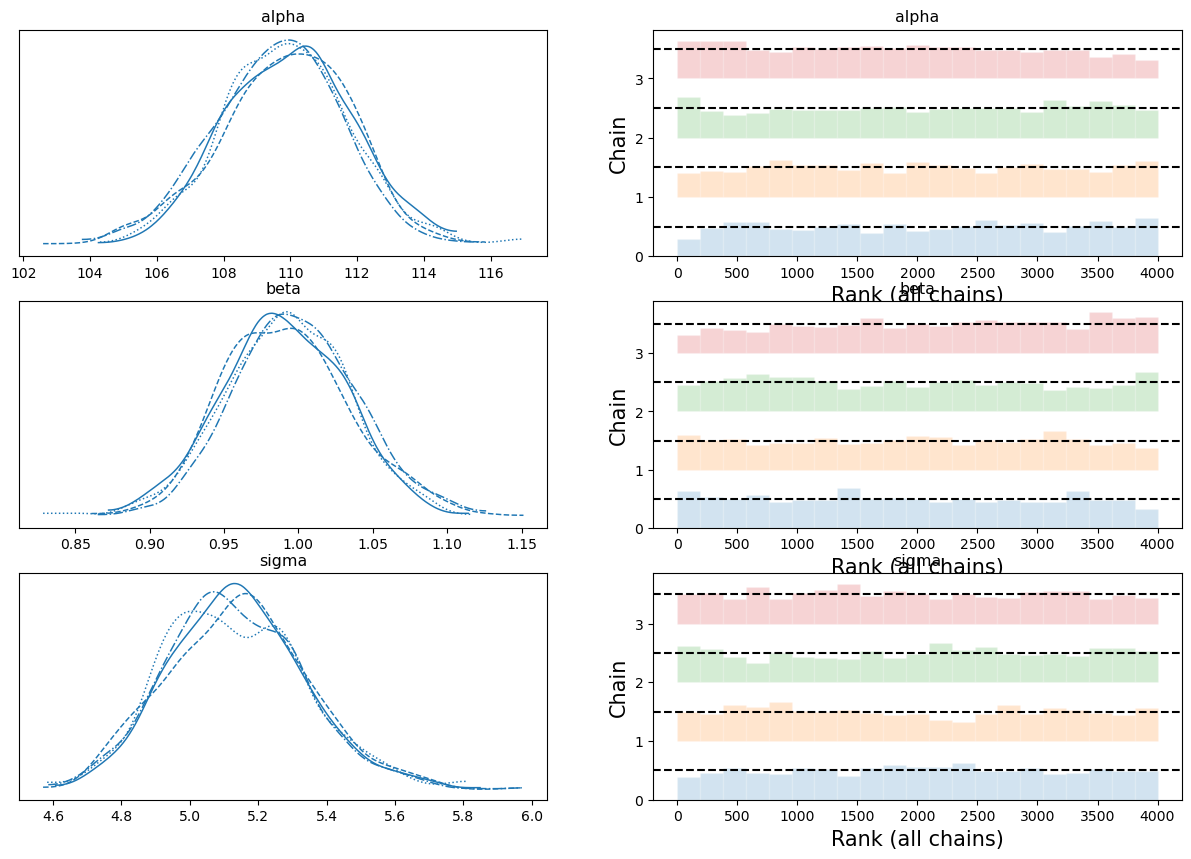

In [12]:
az.plot_trace(idata_howell, kind="rank_bars", figsize=(15,10), compact=True);

In [13]:
# Summary of the model
az.summary(idata_howell)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,109.830,1.943,106.043,113.316,0.055,0.039,1235.0,1585.0,1.0
beta,0.993,0.043,0.918,1.079,0.001,0.001,1223.0,1501.0,1.0
sigma,5.136,0.203,4.743,5.499,0.005,0.003,1873.0,1739.0,1.0


In [14]:
idata_howell

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

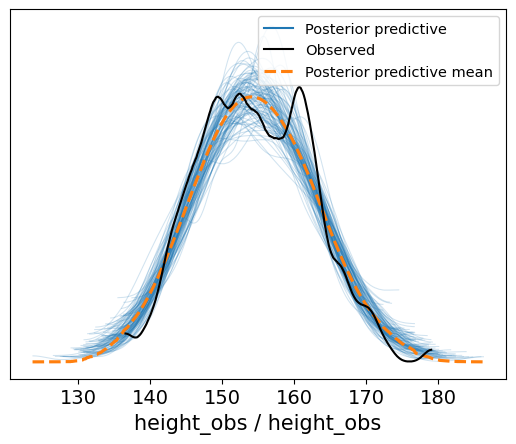

In [15]:
az.plot_ppc(idata_howell, num_pp_samples=100);

# Exercise 2

In [65]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az

# Load and filter the Howell dataset
howell_df = pd.read_csv("../code/data/howell.csv", sep=";")
howell_df = howell_df.query("age >= 18")

n_obs = len(howell_df['weight']) 

# Define the model
with pm.Model() as model_howell:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Use MutableData for weights
    weight = pm.MutableData('weight', howell_df['weight'])
    
    # Expected value of outcome
    mu = alpha + beta * weight
    
    # Likelihood
    height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=howell_df['height'], shape = weight.shape)
    

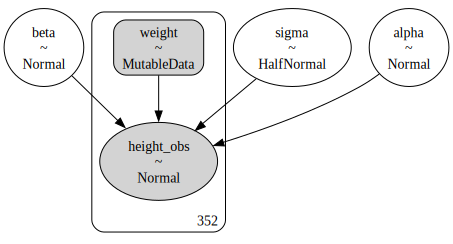

In [66]:
pm.model_to_graphviz(model_howell)

In [67]:
with model_howell:
    idata_howell = pm.sample(return_inferencedata=True)
    idata_howell.extend(pm.sample_prior_predictive())
    idata_howell.extend(pm.sample_posterior_predictive(idata_howell))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [alpha, beta, height_obs, sigma]
Sampling: [height_obs]


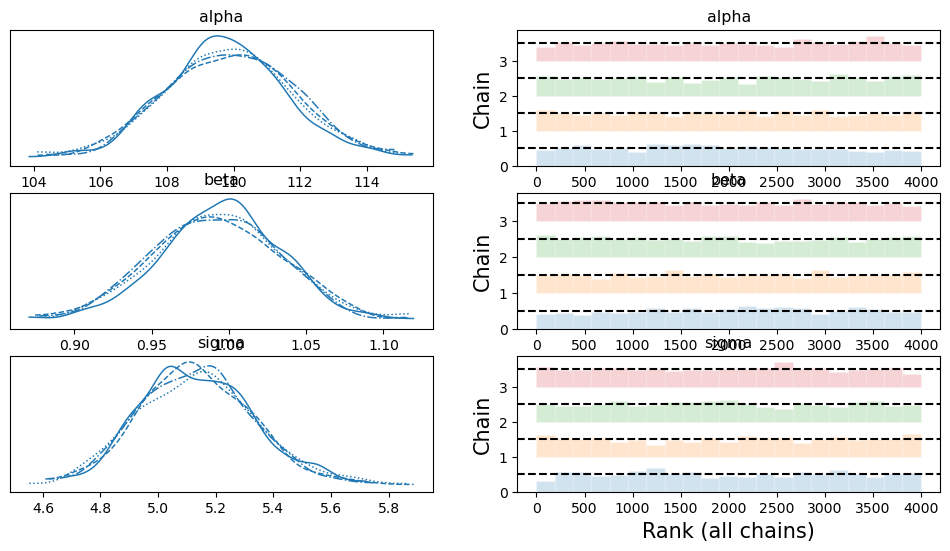

In [68]:
az.plot_trace(idata_howell, kind="rank_bars");

In [ ]:
new_weights = np.array([45.73, 65.8, 54.2, 32.59])

with model_howell:
    pm.set_data({'weight': new_weights})
    idata_howell = pm.sample_posterior_predictive(
        idata_howell, 
        predictions = True,
        extend_inferencedata= True
    )

In [54]:
idata_howell.

<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000, height_obs_dim_2: 4)
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * height_obs_dim_2  (height_obs_dim_2) int64 0 1 2 3
Data variables:
    height_obs        (chain, draw, height_obs_dim_2) float64 158.1 ... 144.4
Attributes:
    created_at:                 2024-04-04T20:01:21.069056
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0

In [74]:
# Calculate HDIs for the new predictions
import arviz as az
predicted_heights = idata_howell.predictions["height_obs"]

hdi_50 = az.hdi(predicted_heights, hdi_prob=0.5)
hdi_94 = az.hdi(predicted_heights, hdi_prob=0.94)

In [79]:
# predicted_heights

In [81]:
idata_howell

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

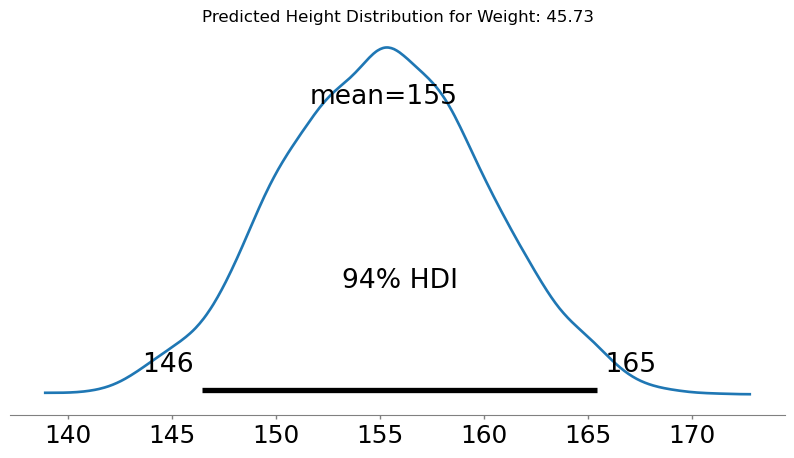

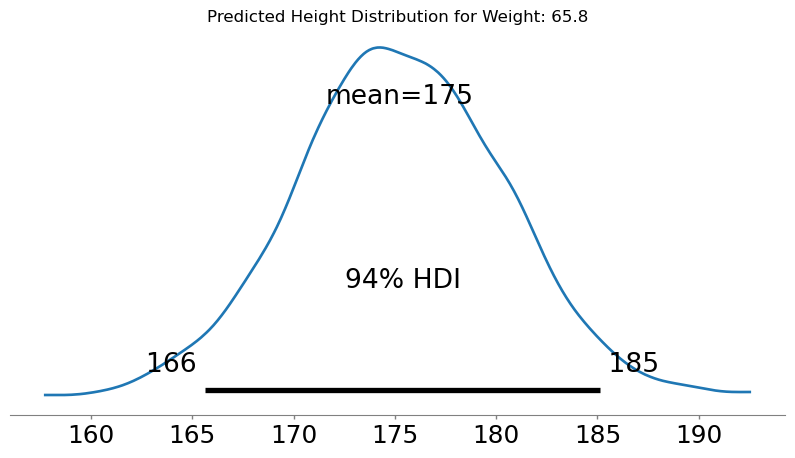

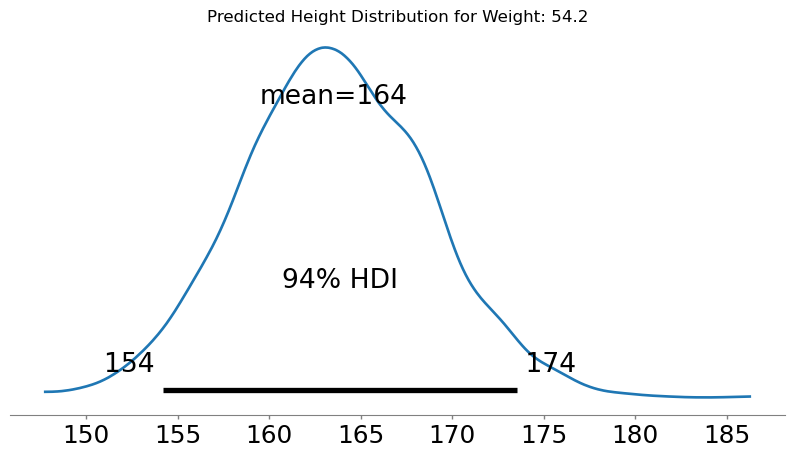

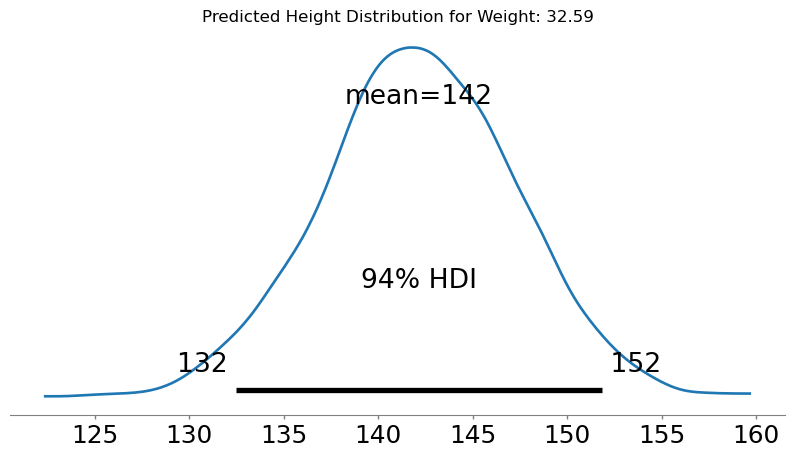

In [88]:
for i, weight in enumerate(new_weights):
    az.plot_posterior(idata_howell.predictions,
                      var_names=['height_obs'],
                      coords={'height_obs_dim_2': [i]},  
                      hdi_prob=0.94,
                      figsize=(10, 5))
    plt.title(f"Predicted Height Distribution for Weight: {weight}")
    plt.show()

## Exercise 3

In [91]:
howell_df = pd.read_csv("../code/data/howell.csv", sep=";")

In [92]:
# Define the model
with pm.Model() as model_howell:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Use MutableData for weights
    weight = pm.MutableData('weight', howell_df['weight'])
    
    # Expected value of outcome
    mu = alpha + beta * weight
    
    # Likelihood
    height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=howell_df['height'], shape = weight.shape)

In [93]:
with model_howell:
    idata_howell = pm.sample(return_inferencedata=True)
    idata_howell.extend(pm.sample_prior_predictive())
    idata_howell.extend(pm.sample_posterior_predictive(idata_howell))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [alpha, beta, height_obs, sigma]
Sampling: [height_obs]


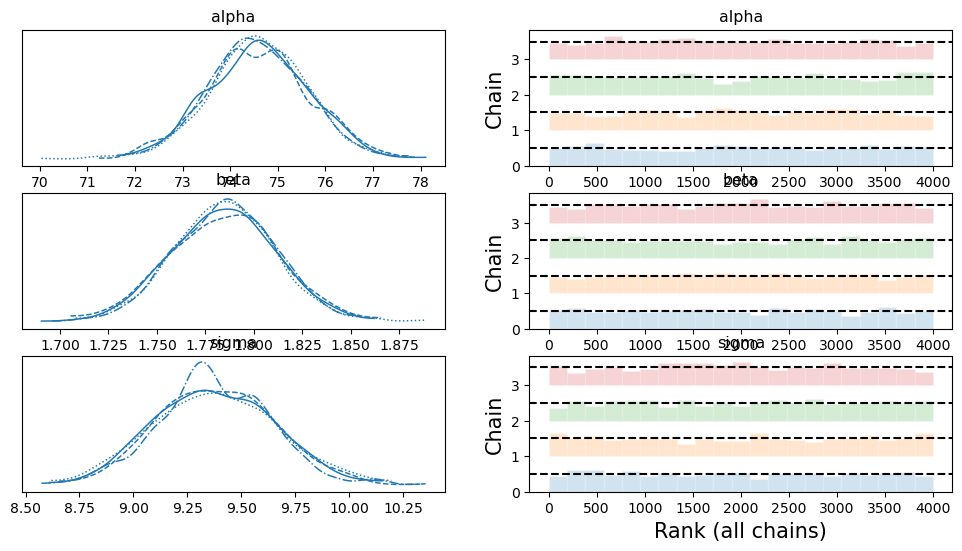

In [94]:
az.plot_trace(idata_howell, kind="rank_bars");

In [95]:
az.summary(idata_howell)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,74.585,1.048,72.609,76.539,0.029,0.020,1339.0,1539.0,1.01
beta,1.785,0.027,1.735,1.837,0.001,0.001,1347.0,1541.0,1.01
sigma,9.380,0.275,8.827,9.861,0.005,0.004,2509.0,2307.0,1.00


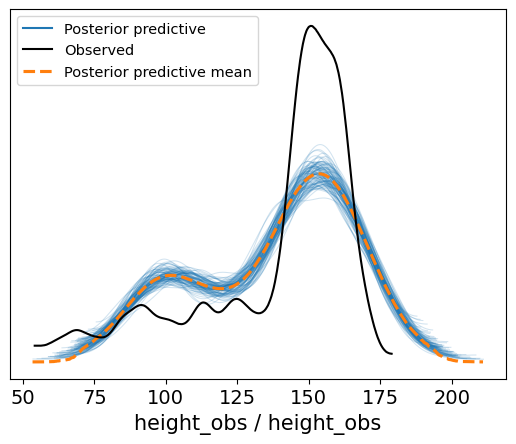

In [98]:
az.plot_ppc(idata_howell, num_pp_samples=100);

## Exercise 4

In [100]:
howell_df = pd.read_csv("../code/data/howell.csv", sep=";")
howell_df["weight_log"] = np.log10(howell_df["weight"])
howell_df.head()

,height,weight,age,male,weight_log
0,151.765,47.825606,63.0,1,1.679660
1,139.700,36.485807,63.0,0,1.562124
2,136.525,31.864838,65.0,0,1.503312
3,156.845,53.041914,41.0,1,1.724619
4,145.415,41.276872,51.0,0,1.615707


In [102]:
# Define the model
with pm.Model() as model_howell_log:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Use MutableData for weights
    weight_log = pm.MutableData('weight_log', howell_df['weight_log'])
    
    # Expected value of outcome
    mu = alpha + beta * weight_log
    
    # Likelihood
    height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=howell_df['height'], shape = weight_log.shape)

In [103]:
with model_howell_log:
    idata_howell_log = pm.sample(return_inferencedata=True)
    idata_howell_log.extend(pm.sample_prior_predictive())
    idata_howell_log.extend(pm.sample_posterior_predictive(idata_howell_log))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [alpha, beta, height_obs, sigma]
Sampling: [height_obs]


In [104]:
az.summary(idata_howell_log)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-22.198,1.382,-24.810,-19.570,0.037,0.026,1406.0,1579.0,1.0
beta,107.342,0.915,105.605,109.058,0.024,0.017,1396.0,1461.0,1.0
sigma,5.159,0.154,4.866,5.452,0.004,0.002,1945.0,1945.0,1.0


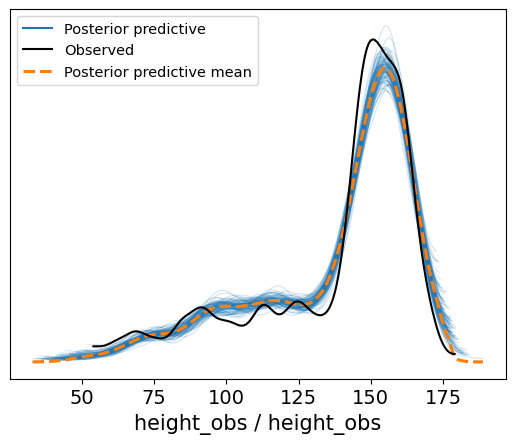

In [107]:
az.plot_ppc(idata_howell_log, num_pp_samples=100);

## Exercise 5 - model_t2

In [111]:
ans.head()

,group,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [ ]:
ans = pd.read_csv('../code/data/anscombe.csv')

x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

In [118]:
with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    # ν = pm.Exponential('ν', 1/30)
    # ν = pm.Gamma('ν', mu=20, sigma=15)
    ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sigma=ϵ, nu=ν, observed=y_4)
    idata_t2 = pm.sample(2000)
    idata_t2.extend(pm.sample_prior_predictive())
    idata_t2.extend(pm.sample_posterior_predictive(idata_t2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
Sampling: [y_pred, α, β, ν, ϵ]
Sampling: [y_pred]


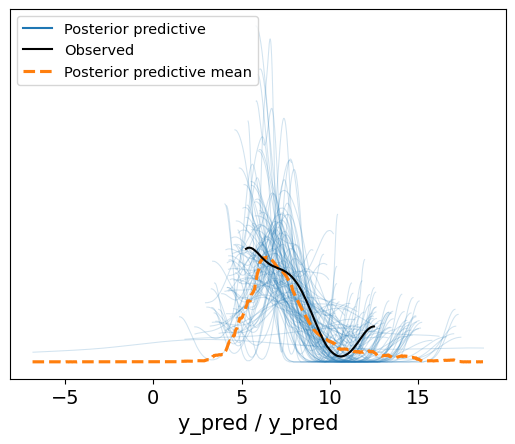

In [119]:
az.plot_ppc(idata_t2,  num_pp_samples=100);

In [120]:
az.summary(idata_t2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.076,1.422,0.492,5.775,0.026,0.020,3081.0,2851.0,1.0
β,0.491,0.150,0.201,0.769,0.003,0.002,3114.0,2767.0,1.0
ϵ,1.395,0.407,0.760,2.136,0.007,0.005,3400.0,2582.0,1.0
ν,21.883,14.155,2.337,48.238,0.195,0.140,4422.0,3592.0,1.0


## Exercise 6

In [121]:
iris = pd.read_csv("../code/data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [122]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'petal_length'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [130]:
with pm.Model() as model_lrs:
    alpha = pm.Normal("mu", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta)  # Boundary decision
    y1 = pm.Bernoulli("y1", p=theta, observed=y_0)
    
    idata_lrs = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [131]:
with model_lrs:
    idata_lrs.extend(pm.sample_posterior_predictive(idata_lrs))

Sampling: [y1]


In [132]:
az.summary(idata_lrs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.307,0.544,-0.788,1.249,0.011,0.009,2535.0,2408.0,1.0
beta,3.060,0.511,2.088,3.991,0.010,0.007,2790.0,2136.0,1.0
theta[0],0.021,0.016,0.000,0.050,0.000,0.000,3551.0,2331.0,1.0
theta[1],0.021,0.016,0.000,0.050,0.000,0.000,3551.0,2331.0,1.0
theta[2],0.016,0.013,0.000,0.039,0.000,0.000,3536.0,2270.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[96],0.983,0.015,0.956,1.000,0.000,0.000,2413.0,1940.0,1.0
theta[97],0.987,0.012,0.965,1.000,0.000,0.000,2418.0,1962.0,1.0
theta[98],0.664,0.115,0.441,0.867,0.002,0.002,2419.0,2406.0,1.0
theta[99],0.978,0.018,0.944,0.999,0.000,0.000,2415.0,2026.0,1.0


In [136]:
# az.plot_ppc(idata_lrs, num_pp_samples=100);

In [137]:
x_n = 'sepal_length'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [138]:
with pm.Model() as model_lrs:
    alpha = pm.Normal("mu", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta)  # Boundary decision
    y1 = pm.Bernoulli("y1", p=theta, observed=y_0)
    
    idata_lrs = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [139]:
with model_lrs:
    idata_lrs.extend(pm.sample_posterior_predictive(idata_lrs))

Sampling: [y1]


In [140]:
az.summary(idata_lrs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.126,0.261,-0.372,0.616,0.004,0.004,3811.0,2779.0,1.0
beta,3.256,0.528,2.236,4.193,0.009,0.006,3849.0,2823.0,1.0
theta[0],0.257,0.055,0.150,0.354,0.001,0.001,3942.0,2809.0,1.0
theta[1],0.156,0.046,0.077,0.245,0.001,0.001,3978.0,2839.0,1.0
theta[2],0.091,0.035,0.032,0.155,0.001,0.000,3973.0,2967.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[96],0.701,0.063,0.582,0.817,0.001,0.001,3776.0,2428.0,1.0
theta[97],0.917,0.038,0.847,0.976,0.001,0.000,3789.0,2723.0,1.0
theta[98],0.257,0.055,0.150,0.354,0.001,0.001,3942.0,2809.0,1.0
theta[99],0.701,0.063,0.582,0.817,0.001,0.001,3776.0,2428.0,1.0


In [141]:
x_n = 'petal_width'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [142]:
with pm.Model() as model_lrs:
    alpha = pm.Normal("mu", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta)  # Boundary decision
    y1 = pm.Bernoulli("y1", p=theta, observed=y_0)
    
    idata_lrs = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [143]:
with model_lrs:
    idata_lrs.extend(pm.sample_posterior_predictive(idata_lrs))

Sampling: [y1]


In [150]:
az.summary(idata_lrs, var_names=["~theta"], kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,0.090,0.329,-0.524,0.703
beta,4.528,0.586,3.458,5.652
bd,-0.020,0.073,-0.159,0.117


In [145]:
help(az.summary)

Help on function summary in module arviz.stats.stats:

summary(data, var_names: Optional[List[str]] = None, filter_vars=None, group=None, fmt: "Literal['wide', 'long', 'xarray']" = 'wide', kind: "Literal['all', 'stats', 'diagnostics']" = 'all', round_to=None, circ_var_names=None, stat_focus='mean', stat_funcs=None, extend=True, hdi_prob=None, skipna=False, labeller=None, coords=None, index_origin=None, order=None) -> Union[pandas.core.frame.DataFrame, xarray.core.dataset.Dataset]
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    data: obj
        Any object that can be converted to an :class:`arviz.InferenceData` object
        Refer to documentation of :func:`arviz.convert_to_dataset` for details
    var_names: list
        Names of variables to include in summary. Prefix the variables by ``~`` when you
        want to exclude them from the summary: `["~beta"]` instead of `["beta"]` (see
        examples below).
    filter_vars: {None, "like", "re

## Exercise 7

In [151]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'petal_length'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [152]:
help(pm.StudentT)

Help on class StudentT in module pymc.distributions.continuous:

class StudentT(pymc.distributions.distribution.Continuous)
 |  StudentT(name: str, *args, rng=None, dims: Union[str, Sequence[Optional[str]], NoneType] = None, initval=None, observed=None, total_size=None, transform=UNSET, **kwargs) -> pytensor.tensor.var.TensorVariable
 |  
 |  Student's T log-likelihood.
 |  
 |  Describes a normal variable whose precision is gamma distributed.
 |  If only nu parameter is passed, this specifies a standard (central)
 |  Student's T.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x|\mu,\lambda,\nu) =
 |         \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})}
 |         \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}}
 |         \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}
 |  
 |  .. plot::
 |      :context: close-figs
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      impor

In [161]:
with pm.Model() as model_lrs:
    # alpha = pm.StudentT("mu", nu=50, mu=0, sigma=1)
    # beta = pm.StudentT("beta", nu=50, mu=0, sigma=1)
    alpha = pm.Normal("mu", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta)  # Boundary decision
    y1 = pm.Bernoulli("y1", p=theta, observed=y_0)
    
    idata_lrs = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [156]:
# nu = 1
az.summary(idata_lrs, kind='stats', var_names=["~theta"])

,mean,sd,hdi_3%,hdi_97%
mu,0.601,1.399,-1.737,3.528
beta,8.663,3.506,3.507,15.351
bd,-0.084,0.179,-0.456,0.230


In [158]:
# nu = 15
az.summary(idata_lrs, kind='stats', var_names=["~theta"])

,mean,sd,hdi_3%,hdi_97%
mu,0.361,0.625,-0.828,1.541
beta,3.592,0.797,2.313,5.186
bd,-0.101,0.173,-0.417,0.238


In [160]:
# nu = 50
# Increasing nu results become more similar to normal
az.summary(idata_lrs, kind='stats', var_names=["~theta"])

,mean,sd,hdi_3%,hdi_97%
mu,0.329,0.561,-0.674,1.417
beta,3.224,0.591,2.200,4.335
bd,-0.100,0.171,-0.408,0.220


In [162]:
# pm.Normal
az.summary(idata_lrs, kind='stats', var_names=["~theta"])

,mean,sd,hdi_3%,hdi_97%
mu,0.318,0.541,-0.641,1.390
beta,3.062,0.496,2.140,3.985
bd,-0.103,0.175,-0.423,0.226
